In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
np.seed=42

In [7]:
df_voice = pd.read_csv("gender_voice_dataset.csv")
df_voice["gender"] = df_voice.apply(lambda row: 1 if row.label == 'male' else 0, axis = 1)
df_voice = df_voice.drop("label",axis=1)

In [10]:
selected_columns = [ 0,  1,  2,  3,  5,  6,  8,  9, 11, 12]
for el in selected_columns:
    print(df_voice.columns[el])

meanfreq
sd
median
Q25
IQR
skew
sp.ent
sfm
centroid
meanfun


In [4]:
columns = df_voice.columns[1:20]   
for column in columns:
    factor = 4
    upper_lim = df_voice[column].mean () + df_voice[column].std () * factor
    lower_lim = df_voice[column].mean () - df_voice[column].std () * factor
    df_voice = df_voice[(df_voice[column] < upper_lim) & (df_voice[column] > lower_lim)]
df_voice.reset_index(inplace = True)
df_voice.drop(axis = 1, columns = ['index'], inplace = True)

In [4]:
from sklearn import preprocessing
df_voice.reset_index(drop=True, inplace=True)
scaler = preprocessing.StandardScaler().fit(df_voice.drop("gender",axis=1))
df_voice_standard = scaler.transform(df_voice.drop("gender",axis=1))
X = df_voice_standard
y = df_voice[['gender']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state = 42)

In [5]:
test1 = SVC(random_state=42).fit(X_train,y_train)
accuracy_score(test1.predict(X_test),y_test)

C:\Users\Dokumenty\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.991869918699187

In [6]:
import warnings
pipe = Pipeline([
    ('feature_selection', SelectKBest(k=10)),
    ('classifier',SVC(random_state=42))
])
warnings.filterwarnings("ignore")
grid = { 'classifier__C' : [0.001,0.01,0.1,10,100,1000],
              'classifier__kernel' : ["rbf","linear", "poly"],
              'classifier__gamma' : [0.0001,0.001,0.01,0.1,1,10,100,'auto','scale']
}
svmt = RandomizedSearchCV(estimator = pipe,param_distributions = grid, cv=5,n_iter=100, random_state=1613)
svmt.fit(X_train,y_train)
accuracy_score(svmt.predict(X_test),y_test)

0.9905149051490515

In [50]:
pipe = Pipeline([
    ('feature_selection', SelectKBest(k=10)),
    ('classifier',SVC(random_state=42))
])
grid = { 'classifier__C' : [6,8,10,12,14,16,18,20],
              'classifier__kernel' : ["rbf"],
              'classifier__gamma' : [0.05,0.1,0.2,0.3,0.5,'auto','scale'],
}
svmt = GridSearchCV(estimator = pipe,param_grid = grid, cv=5,scoring='accuracy')
svmt.fit(X_train,y_train)
accuracy_score(svmt.predict(X_test),y_test)

0.9932249322493225

In [51]:
svm_pred = svmt.predict(X_test)

In [52]:
svmt.best_params_

{'classifier__C': 8, 'classifier__gamma': 0.3, 'classifier__kernel': 'rbf'}

In [67]:
# tutaj widzimy, które zmienne wybrał
sel = SelectKBest(k=10).fit(X_train, y_train)
sel.get_support(True)

array([ 0,  1,  2,  3,  5,  6,  8,  9, 11, 12], dtype=int64)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(svmt, X, y, cv=5,scoring="accuracy").mean()

In [53]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
results = {
    "accuracy" : [accuracy_score(y_test,svm_pred)],
    "precision" : [precision_score(y_test,svm_pred)],
    "recall" :[recall_score(y_test,svm_pred)],
    'ROC AUC' : [roc_auc_score(y_test,svm_pred)]
}
pd.DataFrame(results)


,accuracy,precision,recall,ROC AUC
0,0.993225,0.997183,0.988827,0.993098


In [54]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
pd.DataFrame({"Actual positives": [tp, fp], "Actual negatives": [fn, tn]}, index = ["Positive predictions", "Negative predictions"])

,Actual positives,Actual negatives
Positive predictions,354,4
Negative predictions,1,379


In [55]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test,svm_pred)
roc_auc = auc(fpr, tpr)

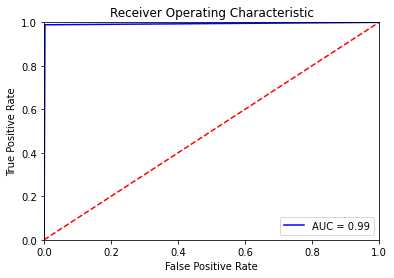

In [56]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()